In [144]:
import pandas as pd
import dfply as df
import scipy.stats as sci_st

In [29]:
money_reserves = (
    pd.read_csv('./API_FM.LBL.BMNY.IR.ZS_DS2_en_csv_v2_6305558/API_FM.LBL.BMNY.IR.ZS_DS2_en_csv_v2_6305558.csv',
                skiprows=3)
    >> df.drop(-1)
    >> df.gather('year', 'money', df.columns_from(4))
    >> df.mutate(
        year=df.X.year.apply(lambda x: int(x))
    )
)

In [45]:
money_growth = (
    pd.read_csv('./API_FM.LBL.BMNY.ZG_DS2_en_csv_v2_6302099/API_FM.LBL.BMNY.ZG_DS2_en_csv_v2_6302099.csv',
                skiprows=3)
    >> df.drop(-1)
    >> df.gather('year', 'money_growth', df.columns_from(4))
    >> df.mutate(
        year=df.X.year.apply(lambda x: int(x))
    )
)

In [46]:
cpi = (
    pd.read_csv('./API_FP.CPI.TOTL_DS2_en_csv_v2_6297715/API_FP.CPI.TOTL_DS2_en_csv_v2_6297715.csv',
                skiprows=3)
    >> df.drop(-1)
    >> df.gather('year', 'cpi', df.columns_from(4))
    >> df.group_by('Country Name', 'Country Code', 'Indicator Name', 'Indicator Code')
    >> df.mutate(
        cpi_change=df.X.cpi.diff() / df.X.cpi,
        year=df.X.year.apply(lambda x: int(x))
    )
)

/Users/march/opt/anaconda3/lib/python3.9/site-packages/dfply/base.py:309: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  dff = grouped.apply(self.function, *args, **kwargs)


In [47]:
countries_1 = ['Australia', 'Austria', 'Canada', 'Switzerland', 'Germany', 'Denmark', 'Spain', 'Finland',
               'United States', 'France', 'Greece', 'Norway']

In [65]:
f_cpi = cpi >> df.mask(df.X.year >= 2010)
f_money_growth = (
    money_growth 
    >> df.mask(df.X.year >= 2010)
    >> df.mutate(money_growth=df.X.money_growth / 100)
)
j = (
    pd.merge(f_cpi, f_money_growth, on=['Country Name', 'Country Code', 'year'])
    >> df.drop('Indicator Name_x', 'Indicator Name_y', 'Indicator Code_x', 'Indicator Code_y')
    >> df.mask(~df.X.cpi_change.isna(), ~df.X.money_growth.isna())
    >> df.gather('type', 'value', ['cpi_change', 'money_growth'])
)

In [71]:
fg = sns.relplot(data=j,
                 x='year', y='value', hue='type', kind='line',
                 col='Country Name', col_wrap=4, facet_kws=dict(sharey=False)
                )
fg.savefig('cpi_change-money_growth.pdf')

In [79]:
df.unite?

In [130]:
gdp = (
    pd.read_excel('mpd2020.xlsx', sheet_name='Full data')
    >> df.mask(df.X.year > 2015)
    >> df.group_by('country')
    >> df.summarize(gdppc=df.X.gdppc.mean())
)

In [146]:
j = (
    pd.merge(f_cpi, f_money_growth, on=['Country Name', 'Country Code', 'year'])
    >> df.rename(country='Country Name')
    >> df.left_join(gdp, on='country')
    >> df.mask(df.X.year > 2019)
    >> df.select('country', 'year', 'cpi_change', 'money_growth', 'gdppc')
    >> df.gather('type', 'value', ['cpi_change', 'money_growth'])
    >> df.unite('full_type', ['year', 'type'], remove=True)
    >> df.group_by('country', 'year')
    >> df.spread('full_type', 'value')
    >> df.gather('mg_type', 'mg_value', ['2020_money_growth', '2021_money_growth'])
)

['year', 'type'] _ True maintain


In [140]:
def country_names(data, color=None, label=None, xlim=10000, ylim=1000):
    for k, r in data.dropna().iterrows():
        if r['mg_value'] < xlim and r['2022_cpi_change'] < ylim:
            plt.text(r['mg_value'], r['2022_cpi_change'], r['country'])

(-0.2, 1.0)

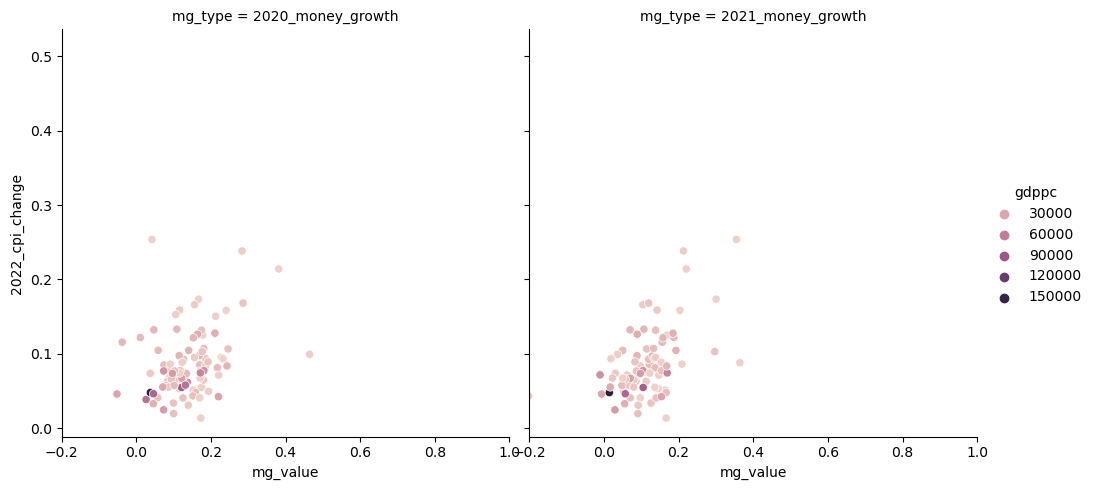

In [141]:
fg = sns.relplot(data=j, x='mg_value', y='2022_cpi_change', col='mg_type', hue='gdppc')
#fg.map_dataframe(country_names, xlim=1)
plt.xlim(-0.2, 1)

(-0.1, 0.2)

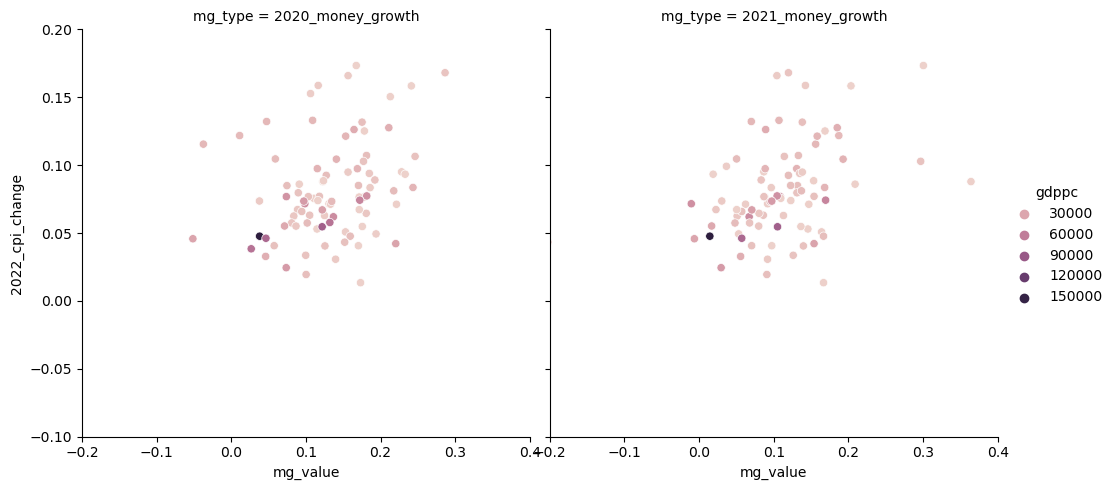

In [143]:
fg = sns.relplot(data=j, x='mg_value', y='2022_cpi_change', col='mg_type', hue='gdppc')
plt.xlim(-0.2, 0.4)
plt.ylim(-0.1, 0.2)

(-0.1, 0.2)

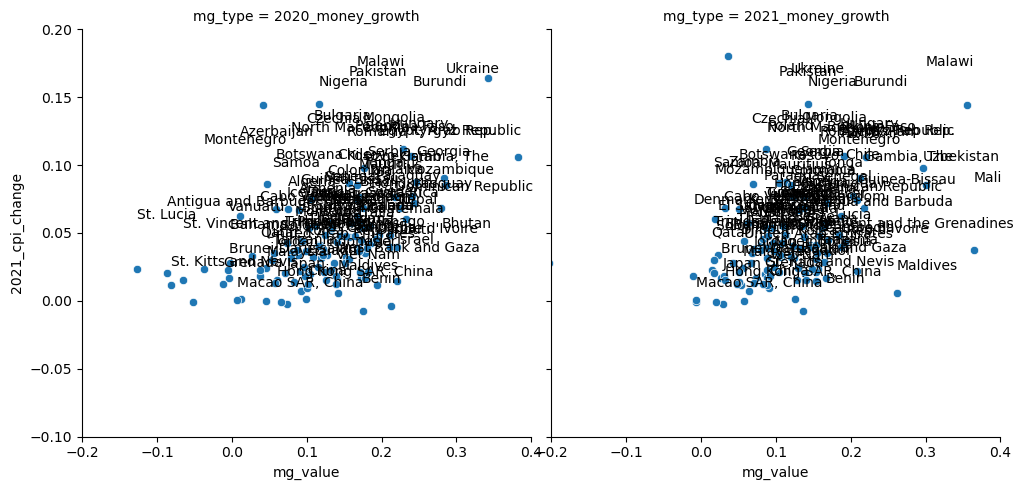

In [116]:
fg = sns.relplot(data=j, x='mg_value', y='2021_cpi_change', col='mg_type')
fg.map_dataframe(country_names, xlim=0.4, ylim=0.2)
plt.xlim(-0.2, 0.4)
plt.ylim(-0.1, 0.2)

In [ ]:
sci_st.spearmanr(j)